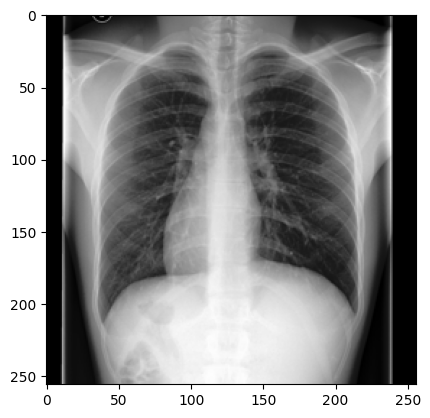

In [11]:
import os
import numpy as np
import PIL
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms


class MIMICBase(Dataset):
    def __init__(self,
                 txt_file,
                 txt_file_labels,
                 data_root,
                 size=None,
                 interpolation="bicubic",
                 flip_p=0.5
                 ):
        self.data_paths = txt_file
        self.data_root = data_root
        with open(self.data_paths, "r") as f:
            self.image_paths = f.read().splitlines()
        with open(txt_file_labels, "r") as f:
            self.labels = f.read().splitlines()
        
        self._length = len(self.image_paths)
        # [[float(label) for label in multilabel.split(",")] for multilabel in all_labels] 
        self.labels = {
            "relative_file_path_": [l for l in self.image_paths],
            "file_path_": [os.path.join(self.data_root, l)+".jpg"
                           for l in self.image_paths],
            "class_label":[[float(label) for label in multilabel.split(",")] for multilabel in self.labels] 
        }

        self.size = size
        self.interpolation = {"bilinear": PIL.Image.BILINEAR,
                              "bicubic": PIL.Image.BICUBIC,
                              "lanczos": PIL.Image.LANCZOS,
                              }[interpolation]
        self.flip = transforms.RandomHorizontalFlip(p=flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = dict((k, self.labels[k][i]) for k in self.labels)
        image = Image.open(example["file_path_"])
        if not image.mode == "RGB":
            image = image.convert("RGB")

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)
        crop = min(img.shape[0], img.shape[1])
        h, w, = img.shape[0], img.shape[1]
        img = img[(h - crop) // 2:(h + crop) // 2,
              (w - crop) // 2:(w + crop) // 2]

        image = Image.fromarray(img)
        if self.size is not None:
            image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip(image)
        image = np.array(image).astype(np.uint8)
        example["image"] = (image / 127.5 - 1.0).astype(np.float32)
        # example["image"] = image
        return example


data = MIMICBase(txt_file="/fs01/home/hhamidi/storage/data/down_sample_train_path.txt", txt_file_labels="/fs01/home/hhamidi/storage/data/down_sample_train_labels.txt", data_root="/datasets/mimic-cxr/physionet.org/files/mimic-cxr-jpg/2.0.0", size=256, interpolation="bicubic", flip_p=0.5)
# plot image 
import matplotlib.pyplot as plt
plt.imshow(((data[0]["image"]+1)*127.5).astype(np.uint8))

(256, 256, 3)